# Variance Starvation

When using Random Fourier Features with Bayes Linear Regression, predictions outside of the sampled domain can have substantially reduced uncertainty, even though there are no data points in that range, typically when there are more samples in the dataset than there are dimensions of the RFF representation.  In this notebook we test Random SSPs and Hexagonal SSPs to see if they demonstrate variance starvation.



## Function Sampled from GP

We select a function to model, randomly drawn from a Gaussian Process.  Our objective is to explore what happens outside of the training dataset, as per [To be linked Wang 2018 paper].

/home/furlong/projects/cnrg/ssp-bayesopt/notebooks/../ssp_bayes_opt/
(5000, 1)
(5000, 5000)


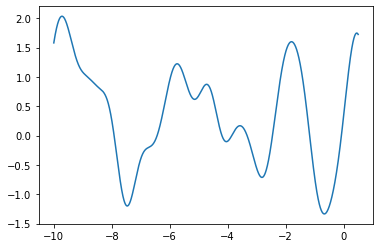

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.gaussian_process.kernels import RBF


import os
notebook_path = os.path.abspath("Variance Starvation.ipynb")

import sys
agent_path = os.path.join(os.path.dirname(notebook_path), '../ssp_bayes_opt/')
print(agent_path)

if not agent_path in sys.path:
    sys.path.append(agent_path)

import sspspace
from scipy.interpolate import interp1d


num_points = 5000
xs = np.atleast_2d(np.linspace(-10,0.5,num_points)).T

kernel = RBF(length_scale=0.5)
K = kernel(xs,xs)
print(xs.shape)
print(K.shape)
ys = np.random.multivariate_normal(np.zeros((num_points,)), K)

func = interp1d(xs.flatten(), ys.flatten())

plt.plot(xs.flatten(), ys)
plt.show()

In [133]:
train_xs = np.linspace(-10, -5, 5000).reshape(-1,1)
train_ys = func(train_xs).reshape(-1,1)

test_xs = np.linspace(-10, 0.5, 5000).reshape(-1,1)
test_ys = func(test_xs).reshape(-1,1)

/home/furlong/installed/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


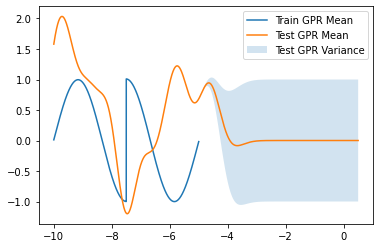

In [134]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel=RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(train_xs, train_ys)

gpr_mu, gpr_std = gpr.predict(test_xs, return_std=True)
gpr_mu = gpr_mu.flatten()

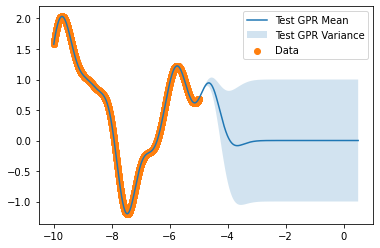

In [136]:

#plt.plot(train_xs, train_gpr_mu, label='Train GPR Mean')
plt.plot(test_xs, gpr_mu, label='Test GPR Mean')
plt.fill_between(test_xs.flatten(), 
                 gpr_mu-gpr_std, 
                 gpr_mu+gpr_std, 
                 alpha=0.2, label='Test GPR Variance')
plt.scatter(train_xs, train_ys, label='Data')
plt.legend()

In [3]:
#subsample = np.random.choice(range(num_points // 2), size=1000, replace=False)

#train_xs = xs[subsample,:]
#train_ys = fs[subsample]

#test_xs = np.linspace(-10, 0.5, 100) 
# Don't need test ys here, as we are just illustrating the collapse of variance 
# outside of training set.

In [137]:
def make_ssp_predictor(train_xs, train_ys, ssp_space):
    train_phis = ssp_space.encode(np.atleast_2d(train_xs))
    blr = BayesianRidge()
    blr.fit(train_phis, train_ys)
    def predictor(test_xs, ssp_space=ssp_space, pred=blr):
        test_phis = ssp_space.encode(np.atleast_2d(test_xs))
        return blr.predict(test_phis, return_std=True)
    return predictor

## Random SSP Representation

Here we take the random SSP representation, where frequency components are drawn from $\mathcal{U}(-\pi,\pi)$

/home/furlong/installed/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: 'x' is not 1-dimensional

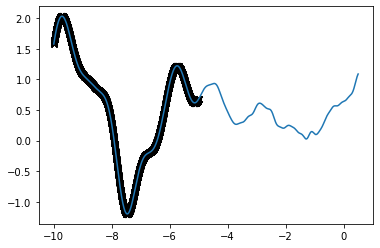

In [138]:
rand_ssp_space = sspspace.RandomSSPSpace(1, 161)
rand_ssp_space.update_lengthscale(1/8)

rand_ssp_pred = make_ssp_predictor(train_xs, train_ys.fla, rand_ssp_space)
mus, stds = rand_ssp_pred(test_xs)

plt.plot(test_xs, mus, label='Mean')
plt.scatter(train_xs, train_ys, marker='x', color='k', label='Data')
plt.fill_between(test_xs, mus-stds, mus+stds, alpha=0.2, label='Variance')
plt.plot(xs, fs, label='True', ls='--')
#plt.xlim([-x_max,x_max])
plt.legend()

## Hexagonal SSP Representation

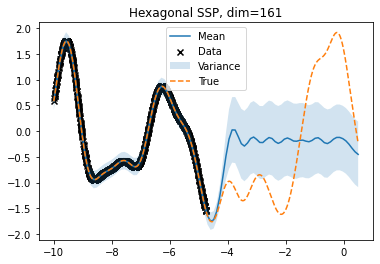

In [8]:
hex_ssp_space = sspspace.HexagonalSSPSpace(1, n_scales=35, scale_max=8)
hex_ssp_space.update_lengthscale(1/4)

hex_ssp_pred = make_ssp_predictor(train_xs, train_ys, hex_ssp_space)
mus, stds = hex_ssp_pred(test_xs)

plt.plot(test_xs, mus, label='Mean')
plt.scatter(train_xs, train_ys, marker='x', color='k', label='Data')
plt.fill_between(test_xs, mus-stds, mus+stds, alpha=0.2, label='Variance')
plt.plot(xs, fs, label='True', ls='--')
#plt.xlim([-x_max,x_max])
plt.title(f'Hexagonal SSP, dim={hex_ssp_space.ssp_dim}')
plt.legend()

# Noisy Sinusoid 1

Using a Sinusoidal signal with Zero-meaned noise with std of 0.1

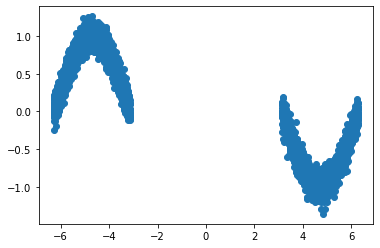

In [114]:
train_xs = np.atleast_2d(
            np.hstack((np.linspace(-2*np.pi, -np.pi, 2500),
                       np.linspace(np.pi, 2*np.pi,2500)))
            ).T
train_ys = np.sin(train_xs) + np.random.normal(loc=0,scale=0.1,size=train_xs.shape)

test_xs = np.atleast_2d(np.linspace(-np.pi, np.pi, 100)).T
test_ys = np.sin(test_xs)

plt.scatter(train_xs, train_ys)

In [80]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel=RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(train_xs, train_ys)

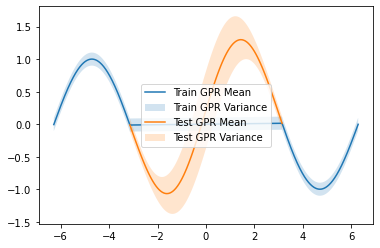

In [83]:
train_gpr_mu, train_gpr_std = gpr.predict(train_xs, return_std=True)
train_gpr_mu = train_gpr_mu.flatten()

gpr_mu, gpr_std = gpr.predict(test_xs, return_std=True)
gpr_mu = gpr_mu.flatten()


plt.plot(train_xs, train_gpr_mu, label='Train GPR Mean')
plt.fill_between(train_xs.flatten(), 
                 train_gpr_mu-train_gpr_std, 
                 train_gpr_mu+train_gpr_std, 
                 alpha=0.2, label='Train GPR Variance')
plt.plot(test_xs, gpr_mu, label='Test GPR Mean')
plt.fill_between(test_xs.flatten(), 
                 gpr_mu-gpr_std, 
                 gpr_mu+gpr_std, 
                 alpha=0.2, label='Test GPR Variance')
#plt.scatter(train_xs, train_ys, label='Data')
plt.legend()

# SSP models

(100,)


Text(0.5, 1.0, 'Hex SSP')

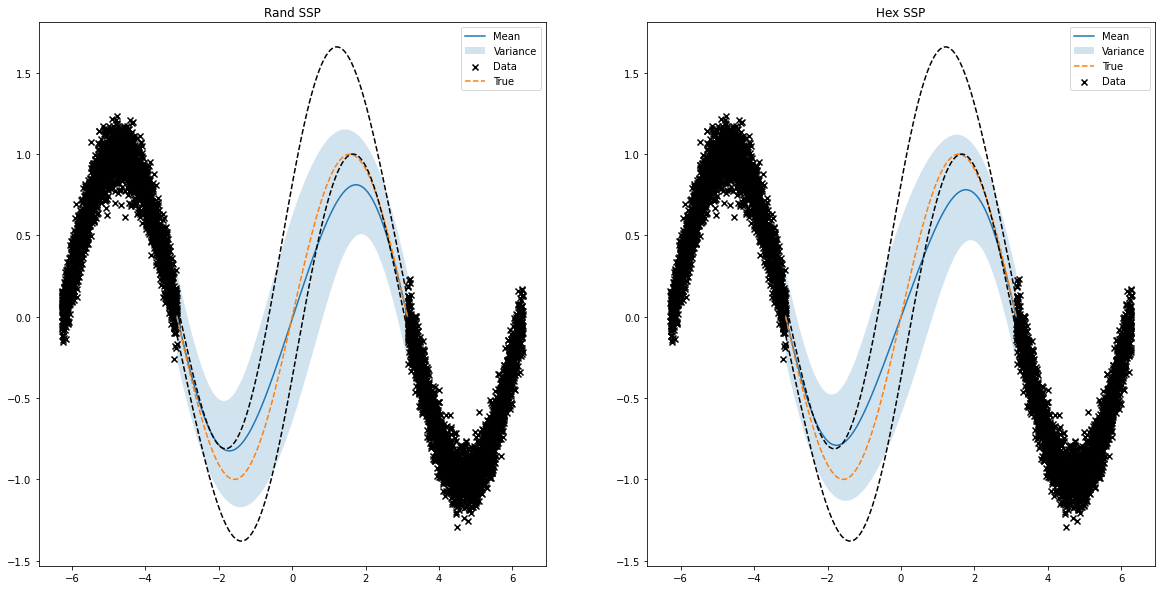

In [106]:
len_scale = 1.5
rand_ssp_space = sspspace.RandomSSPSpace(1, 161)
rand_ssp_space.update_lengthscale(len_scale)

hex_ssp_space = sspspace.HexagonalSSPSpace(1, n_scales=35, scale_max=8)
hex_ssp_space.update_lengthscale(len_scale)

rand_ssp_pred = make_ssp_predictor(train_xs, train_ys.flatten(), rand_ssp_space)
rand_mus, rand_stds = rand_ssp_pred(test_xs)
print(stds.shape)

hex_ssp_pred = make_ssp_predictor(train_xs, train_ys.flatten(), hex_ssp_space)
hex_mus, hex_stds = hex_ssp_pred(test_xs)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(test_xs, rand_mus, label='Mean')
plt.fill_between(test_xs.flatten(), 
                 rand_mus-rand_stds, 
                 rand_mus+rand_stds, 
                 alpha=0.2, label='Variance')
plt.scatter(train_xs, train_ys, marker='x', color='k', label='Data')
plt.plot(test_xs, np.sin(test_xs), label='True', ls='--')

plt.plot(test_xs, gpr_mu - gpr_std, ls='--', c='k')
plt.plot(test_xs, gpr_mu + gpr_std, ls='--', c='k')
plt.legend()
plt.title(f'Rand SSP, {rand_ssp_space.ssp_dim} dim')

plt.subplot(1,2,2)
plt.plot(test_xs, hex_mus, label='Mean')
plt.fill_between(test_xs.flatten(), 
                 hex_mus-hex_stds, 
                 hex_mus+hex_stds, 
                 alpha=0.2, label='Variance')
plt.plot(test_xs, np.sin(test_xs), label='True', ls='--')
plt.scatter(train_xs, train_ys, marker='x', color='k', label='Data')
plt.plot(test_xs, gpr_mu - gpr_std, ls='--', c='k')
plt.plot(test_xs, gpr_mu + gpr_std, ls='--', c='k')
plt.legend()
plt.title(f'Hex SSP, {rand_ssp_space.ssp_dim} dim')


(100,)


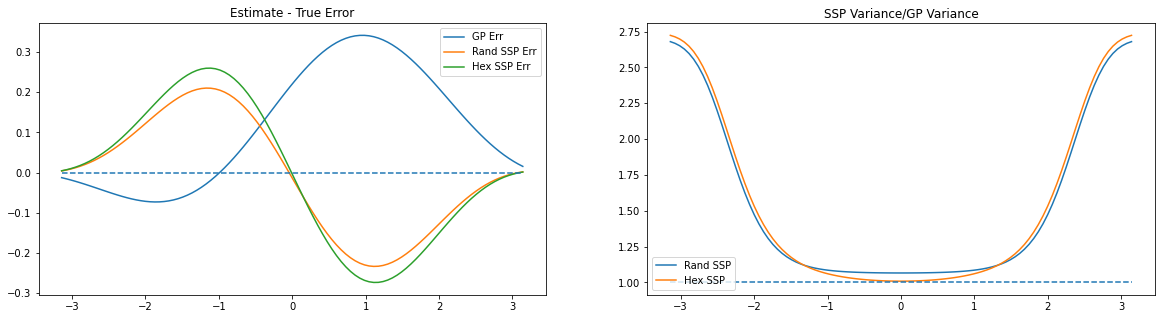

In [122]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(test_xs, np.divide(rand_stds, gpr_std), label='Rand SSP')
plt.plot(test_xs, np.divide(hex_stds, gpr_std), label='Hex SSP')
plt.hlines([1], -np.pi, np.pi, ls='--')
plt.title('SSP Variance/GP Variance')
plt.legend()

plt.subplot(1,2,1)
print((gpr_mu - test_ys.flatten()).shape)
plt.plot(test_xs, gpr_mu - test_ys.flatten(), label='GP Err')
plt.plot(test_xs, rand_mus - test_ys.flatten(), label='Rand SSP Err')
plt.plot(test_xs, hex_mus - test_ys.flatten(), label='Hex SSP Err')
plt.hlines([0], -np.pi, np.pi, ls='--')
plt.title('Estimate - True Error')


plt.legend()


# Noisy Sinusoid 2

Using a Sinusoidal signal with Zero-meaned noise with std of 0.1

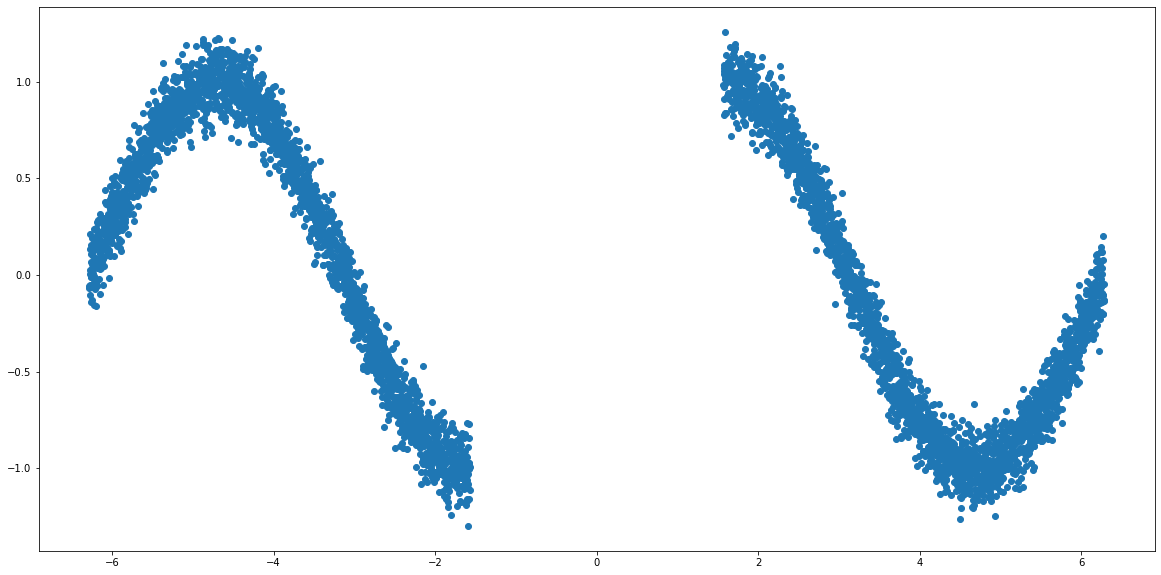

In [124]:
train_xs = np.atleast_2d(
            np.hstack((np.linspace(-2*np.pi, -np.pi/2, 2500),
                       np.linspace(np.pi/2, 2*np.pi,2500)))
            ).T
train_ys = np.sin(train_xs) + np.random.normal(loc=0,scale=0.1,size=train_xs.shape)

test_xs = np.atleast_2d(np.linspace(-np.pi, np.pi, 100)).T
test_ys = np.sin(test_xs)

plt.figure(figsize=(20,10))
plt.scatter(train_xs, train_ys)

In [125]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel=RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(train_xs, train_ys)

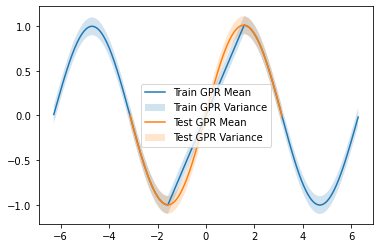

In [126]:
train_gpr_mu, train_gpr_std = gpr.predict(train_xs, return_std=True)
train_gpr_mu = train_gpr_mu.flatten()

gpr_mu, gpr_std = gpr.predict(test_xs, return_std=True)
gpr_mu = gpr_mu.flatten()


plt.plot(train_xs, train_gpr_mu, label='Train GPR Mean')
plt.fill_between(train_xs.flatten(), 
                 train_gpr_mu-train_gpr_std, 
                 train_gpr_mu+train_gpr_std, 
                 alpha=0.2, label='Train GPR Variance')
plt.plot(test_xs, gpr_mu, label='Test GPR Mean')
plt.fill_between(test_xs.flatten(), 
                 gpr_mu-gpr_std, 
                 gpr_mu+gpr_std, 
                 alpha=0.2, label='Test GPR Variance')
#plt.scatter(train_xs, train_ys, label='Data')
plt.legend()

(100,)


Text(0.5, 1.0, 'Hex SSP')

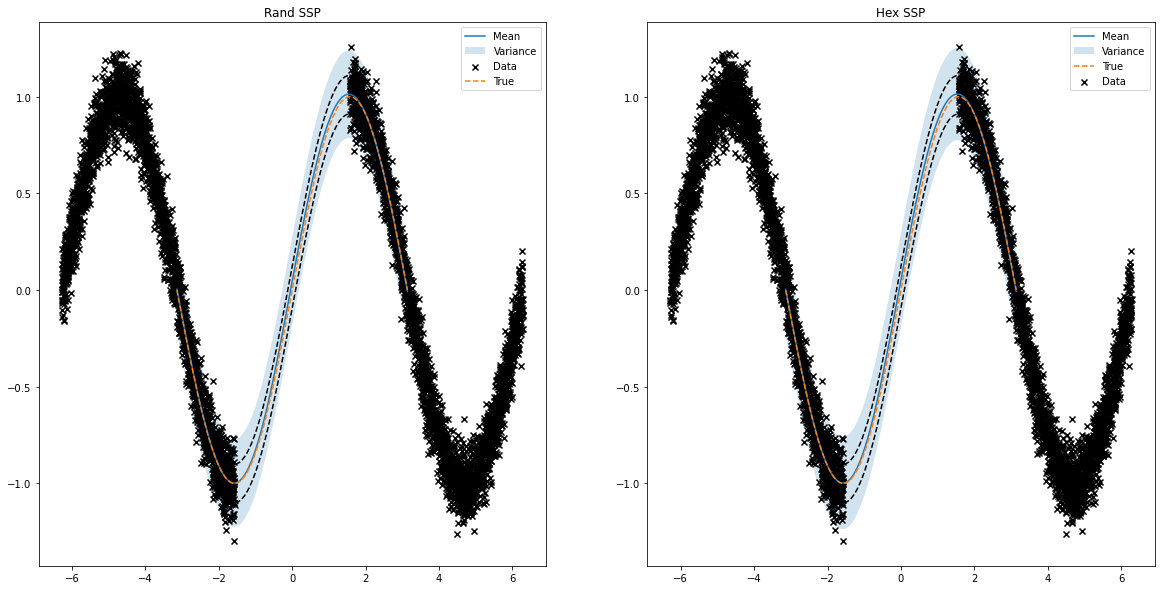

In [127]:
len_scale = 1.5
rand_ssp_space = sspspace.RandomSSPSpace(1, 161)
rand_ssp_space.update_lengthscale(len_scale)

hex_ssp_space = sspspace.HexagonalSSPSpace(1, n_scales=35, scale_max=8)
hex_ssp_space.update_lengthscale(len_scale)

rand_ssp_pred = make_ssp_predictor(train_xs, train_ys.flatten(), rand_ssp_space)
rand_mus, rand_stds = rand_ssp_pred(test_xs)
print(stds.shape)

hex_ssp_pred = make_ssp_predictor(train_xs, train_ys.flatten(), hex_ssp_space)
hex_mus, hex_stds = hex_ssp_pred(test_xs)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(test_xs, rand_mus, label='Mean')
plt.fill_between(test_xs.flatten(), 
                 rand_mus-rand_stds, 
                 rand_mus+rand_stds, 
                 alpha=0.2, label='Variance')
plt.scatter(train_xs, train_ys, marker='x', color='k', label='Data')
plt.plot(test_xs, np.sin(test_xs), label='True', ls='--')

plt.plot(test_xs, gpr_mu - gpr_std, ls='--', c='k')
plt.plot(test_xs, gpr_mu + gpr_std, ls='--', c='k')
plt.legend()
plt.title('Rand SSP')

plt.subplot(1,2,2)
plt.plot(test_xs, hex_mus, label='Mean')
plt.fill_between(test_xs.flatten(), 
                 hex_mus-hex_stds, 
                 hex_mus+hex_stds, 
                 alpha=0.2, label='Variance')
plt.plot(test_xs, np.sin(test_xs), label='True', ls='--')
plt.scatter(train_xs, train_ys, marker='x', color='k', label='Data')
plt.plot(test_xs, gpr_mu - gpr_std, ls='--', c='k')
plt.plot(test_xs, gpr_mu + gpr_std, ls='--', c='k')
plt.legend()
plt.title('Hex SSP')


(100,)


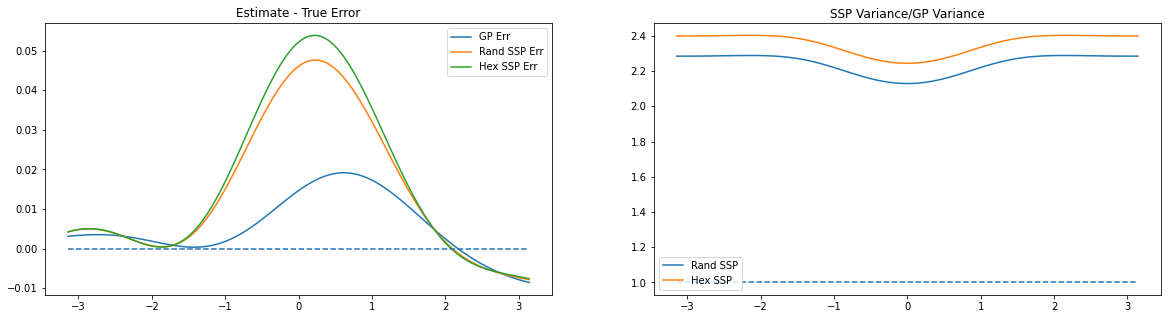

In [128]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(test_xs, np.divide(rand_stds, gpr_std), label='Rand SSP')
plt.plot(test_xs, np.divide(hex_stds, gpr_std), label='Hex SSP')
plt.hlines([1], -np.pi, np.pi, ls='--')
plt.title('SSP Variance/GP Variance')
plt.legend()

plt.subplot(1,2,1)
print((gpr_mu - test_ys.flatten()).shape)
plt.plot(test_xs, gpr_mu - test_ys.flatten(), label='GP Err')
plt.plot(test_xs, rand_mus - test_ys.flatten(), label='Rand SSP Err')
plt.plot(test_xs, hex_mus - test_ys.flatten(), label='Hex SSP Err')
plt.hlines([0], -np.pi, np.pi, ls='--')
plt.title('Estimate - True Error')


plt.legend()
